In [1]:
from train_model import LoadModelandScalers_pytorch
# from epics import caget, caput
from time import sleep
import numpy as np
from MPC import run_newtons_method, getfreq
from matplotlib import pyplot as plt

# fake caget and caput functions for testing
def caput(pv, value):
    print(f'caput {pv} {value}')
def caget(pv):
    global a
    test = np.loadtxt('test_sample.txt')   # delayed variables, future control actions, frq, future frq
    otherPVList = ['FE_LCW1:TI_N0104:T_RD', 'FE_LCW1:FE_N0103:F_RD', 'FE_LCW2:TI_N0205:T_RD', 
                     'FE_LCW2:TI_N0207:T_RD', 'FE_LCW2:PI_N0201:P_RD', 'FE_LCW2:PI_N0205:P_RD', 
                    #  'FE_RFQ:RFC_D1005:E_RD_CAVS', 'FE_RFQ:RFC_D1005:POWR_RD_FWDS', 'FE_RFQ:RFC_D1005:POWR_RD_RFLS',
                     'FE_LCW1:CV_N0102:POS_RD_PLC', 'FE_LCW1:CV_N0103:POS_RD_PLC', 
                     'FE_LCW2:CV_N0202:POS_RD_PLC', 'FE_LCW2:CV_N0203:POS_RD_PLC']
    if pv in otherPVList:
        return test[:,otherPVList.index(pv)][np.mod(a, 60)]
    if pv == 'FE_RFQ:RFC_D1005:FR_RD_ERR':
        return test[:, 12][np.mod(a, 60)]
    if pv == 'FE_LCW2:CV_N0202:MAN_CSET' or pv == 'FE_LCW2:CV_N0202:POS_RD_PLC':
        return test[:, 8][np.mod(a, 60)]
    if pv == 'FE_LCW2:CV_N0203:MAN_CSET' or pv == 'FE_LCW2:CV_N0203:POS_RD_PLC':
        return test[:, 9][np.mod(a, 60)]
    
    print('error')
    # erro

def measure_control_offset():
    # measure the offset of the control valves CV2 and CV3
    CV2_manual = 'FE_LCW2:CV_N0202:MAN_CSET'
    CV3_manual = 'FE_LCW2:CV_N0203:MAN_CSET'
    CV2_readback = 'FE_LCW2:CV_N0202:POS_RD_PLC'
    CV3_readback = 'FE_LCW2:CV_N0203:POS_RD_PLC'
    offset_CV2 = caget(CV2_manual) - caget(CV2_readback)
    offset_CV3 = caget(CV3_manual) - caget(CV3_readback)
    return offset_CV2, offset_CV3


def apply_constraint(u1, u2, lower_bound=5, upper_bound=75, max_delta=2):
    CV2_manual = 'FE_LCW2:CV_N0202:MAN_CSET'
    CV3_manual = 'FE_LCW2:CV_N0203:MAN_CSET'
    CV2_old = caget(CV2_manual)
    CV3_old = caget(CV3_manual)
    if u1 > upper_bound:
        u1 = upper_bound
    elif u1 < lower_bound:
        u1 = lower_bound
    if u2 > upper_bound:
        u2 = upper_bound
    elif u2 < lower_bound:
        u2 = lower_bound
    
    if u1 - CV2_old > max_delta:
        u1 = CV2_old + max_delta
    elif u1 - CV2_old < -max_delta:
        u1 = CV2_old - max_delta
    if u2 - CV3_old > max_delta:
        u2 = CV3_old + max_delta
    elif u2 - CV3_old < -max_delta:
        u2 = CV3_old - max_delta
    return u1, u2
        


KeyboardInterrupt: 

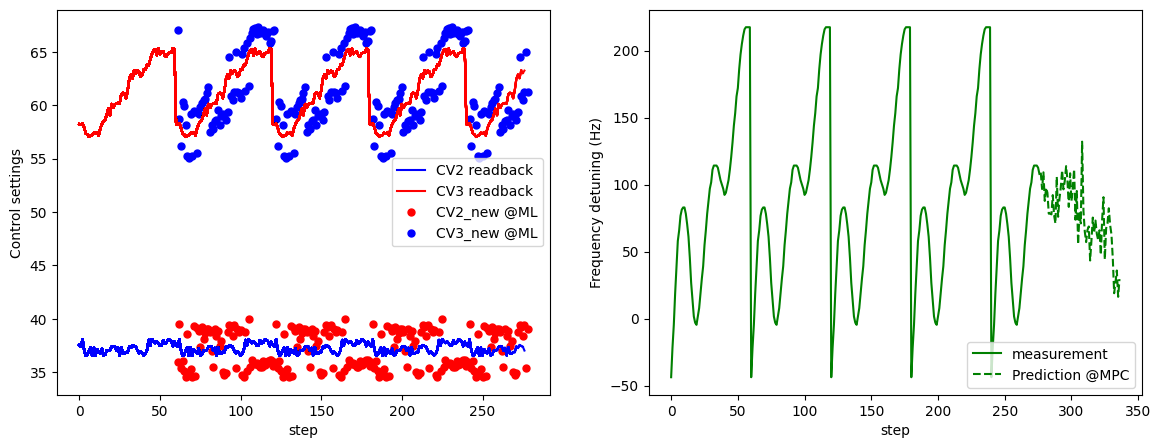

In [32]:
from IPython.display import display, clear_output

interval = 0.1
frequency_error_threshold = 5000.0
start_step = 60
length_input = 60
    
# control settings constraints
lower_bound = 5
upper_bound = 75
max_delta = 2
    
# PV list
FreqPV = 'FE_RFQ:RFC_D1005:FR_RD_ERR'
    

otherPVList = ['FE_LCW1:TI_N0104:T_RD', 'FE_LCW1:FE_N0103:F_RD', 'FE_LCW2:TI_N0205:T_RD', 
                    'FE_LCW2:TI_N0207:T_RD', 'FE_LCW2:PI_N0201:P_RD', 'FE_LCW2:PI_N0205:P_RD', 
                    #  'FE_RFQ:RFC_D1005:E_RD_CAVS', 'FE_RFQ:RFC_D1005:POWR_RD_FWDS', 'FE_RFQ:RFC_D1005:POWR_RD_RFLS',
                    'FE_LCW1:CV_N0102:POS_RD_PLC', 'FE_LCW1:CV_N0103:POS_RD_PLC', 
                    'FE_LCW2:CV_N0202:POS_RD_PLC', 'FE_LCW2:CV_N0203:POS_RD_PLC']
    
CV2_manual = 'FE_LCW2:CV_N0202:MAN_CSET'
CV3_manual = 'FE_LCW2:CV_N0203:MAN_CSET'
    
# load the model and scalers
dir = 'torch_model'
model, sc_d, sc_f= LoadModelandScalers_pytorch(dir)
    
FreqHistory = []
DelayedHistory = [[], [], [], [], [], [], [], [], [], []]
    
# change to manual control mode
# caput('FE_LCW2:CV_N0202:MAN_CMD', 1)
# caput('FE_LCW2:CV_N0203:MAN_CMD', 1)
    
count = 0
a = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
u1_new_points = []
u2_new_points = []
while True:
    # return to automatic control mode when frequency detuning is too large
    # if abs(caget('FE_RFQ:RFC_D1005:FR_RD_ERR')) > frequency_error_threshold:
    #     # valve automatic control mode
    #     caput('FE_LCW1:CV_N0102:MAN_CMD', 0)
    #     caput('FE_LCW1:CV_N0103:MAN_CMD', 0)
    #     caput('FE_LCW2:CV_N0202:MAN_CMD', 0)
    #     caput('FE_LCW2:CV_N0203:MAN_CMD', 0)
    #     # wall skid frequency control mode
    #     caput('FE_LCW2:SYS_N0200:FR_CMD', 1)
        
    # record data
    FreqHistory.append(caget(FreqPV))
    for i in range(len(otherPVList)):
        DelayedHistory[i].append(caget(otherPVList[i]))

    # start control after enough data is recorded
    if len(FreqHistory) >= start_step:
        trainu_con = np.zeros((length_input, 10))
        trainx_con = np.zeros((length_input, 1))
        for i in range(length_input):
            trainu_con[i, 0] = DelayedHistory[0][i+count]
            trainu_con[i, 1] = DelayedHistory[1][i+count]
            trainu_con[i, 2] = DelayedHistory[2][i+count]
            trainu_con[i, 3] = DelayedHistory[3][i+count]
            trainu_con[i, 4] = DelayedHistory[4][i+count]
            trainu_con[i, 5] = DelayedHistory[5][i+count]
            trainu_con[i, 6] = DelayedHistory[6][i+count]
            trainu_con[i, 7] = DelayedHistory[7][i+count]
            trainu_con[i, 8] = DelayedHistory[8][i+count]
            trainu_con[i, 9] = DelayedHistory[9][i+count]
            trainx_con[i, 0] = FreqHistory[i+count]
            
        # old control settings (readback values)
        u1 = DelayedHistory[8][-1]
        u2 = DelayedHistory[9][-1]
            
        # run Newton's method to update control settings
        u1_new, u2_new = run_newtons_method(u1, u2, trainx_con, trainu_con, model, sc_d, sc_f, lower_bound, upper_bound, max_delta)
            
        # adjust control settings based on the offsets between setpoints and readbacks
        offset_CV2, offset_CV3 = measure_control_offset()
        u1_new = u1_new + offset_CV2
        u2_new = u2_new + offset_CV3
        
        obj, freq = getfreq(u1_new, u2_new, trainx_con, trainu_con, model, sc_d, sc_f, 0)
        # apply constraints to control settings
        u1_new, u2_new = apply_constraint(u1_new, u2_new, lower_bound, upper_bound, max_delta)
        # caput(CV2_manual, u1_new)
        # caput(CV3_manual, u2_new)
        
        # plot the CV2 and CV3 control settings
        u1_new_points.append(u1_new)
        u2_new_points.append(u2_new)
        clear_output(wait=True)
        # ax.clear()
        ax1.plot(DelayedHistory[8], 'b', label='CV2 readback')
        ax1.plot(DelayedHistory[9], 'r', label='CV3 readback')
    
        ax1.plot(len(DelayedHistory[8]) + 1, u1_new, 'ro', label='CV2_new @ML', markersize=5)
        ax1.plot(len(DelayedHistory[9]) + 1, u2_new, 'bo', label='CV3_new @ML', markersize=5)
        ax1.set_xlabel('step')
        ax1.set_ylabel('Control settings')
        if count == 0:
            ax1.legend()
        
        ax2.clear()
        ax2.plot(FreqHistory, 'g', label='measurement')
        ax2.plot(range(len(FreqHistory), len(FreqHistory)+60), freq, 'g--', label='Prediction @MPC', markersize=5)
        ax2.legend()
        ax2.set_xlabel('step')
        ax2.set_ylabel('Frequency detuning (Hz)')
        display(fig)
            
        print(count, 'th step, CV2:', u1_new, 'CV3:', u2_new)
        count += 1
            
    a += 1
    sleep(interval)